4.SEMI SUPERVISED EM



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
PLOT_COLORS = ['red', 'green', 'blue', 'orange']  # Colors for plots
K = 4           # Number of Gaussians in the mixture model
NUM_TRIALS = 3  # Number of trials to run (can be adjusted for debugging)
UNLABELED = -1  # Cluster label for unlabeled data points (do not change)


In [3]:
def main(problem_type,trial_num):
    """PS3_Problem 4: EM for Gaussian Mixture Models (unsupervised and semi-supervised)
    
    Args:
           problem_type:String mentioning semi_supervised/unsupervised status of the problem
           trial_num: 't'th trial
    
    """
    print(f'Running {problem_type} EM algorithm...')
    
    if problem_type=='semi_supervised':
        is_semi_supervised=1
    else:
        is_semi_supervised=0
    data=pd.read_csv(r'ds3_train.csv')
    x_tr=data.loc[:,['x_1','x_2']]
    z_tr=data.loc[:,['z']]
    x=x_tr.values
    z=z_tr.values

    x_tilde = None

    if is_semi_supervised:
    # Split into labeled and unlabeled examples
        labeled_idxs = np.where((z != UNLABELED))[0]
        x_tilde = x[labeled_idxs, :]   # Labeled examples
        x=x[np.where((z == UNLABELED))[0], :]  # Unlabeled examples
        z=z[labeled_idxs, :]         # Corresponding labels
    
    # (1) Initialize mu and sigma by splitting the m data points uniformly at random
    # into K groups, then calculating the sample mean and covariance for each group
    # (2) Initialize phi to place equal probability on each Gaussian
    # phi should be a numpy array of shape (K,)
    # (3) Initialize the w values to place equal probability on each Gaussian
    # w should be a numpy array of shape (m, K)

    m,n=x.shape
    tr_ex_ind=np.arange(m)
    np.random.shuffle(tr_ex_ind)
    groups=np.array([tr_ex_ind[0:int(m/K)],tr_ex_ind[int(m/K):int(2*m/K)],tr_ex_ind[int(2*m/K):int(3*m/K)],tr_ex_ind[int(3*m/K):m]])
    
    #groups=np.array_split(tr_ex_ind,K) ##another way

    mu=[]
    sigma=[]
    for i in groups:
        me=np.mean(x[i,:],axis=0)
        mu.append(me)
        sigma.append((1/m)*(((x[i,:]-me).T)@(x[i,:]-me)))
    phi=np.ones(K)/K
    w=np.ones((m,K))/K
    
    if is_semi_supervised:
        w=run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma)
    else:
        w=run_em(x, w, phi, mu, sigma)
    
    # Plot your predictions
    z_pred = np.zeros(m)
    if w is not None:  # Just a placeholder for the starter code
        for i in range(m):
            z_pred[i] = np.argmax(w[i])

    plot_gmm_preds(x, z_pred, is_semi_supervised, plot_id=trial_num)


In [4]:
#For determining the weight matrix


def gaussian(x,mu,sigma,phi,label,z=None):
    m=x.shape[0]
    l=[]
    exp_term=np.exp(-0.5*(np.reshape(((x[:,np.newaxis,None]-np.array(mu)[:,None])@(np.linalg.inv(sigma))@(np.transpose((x[:,np.newaxis,None]-np.array(mu)[:,None]),(0,1,3,2)))),(m,4))))
    w_nume=(exp_term*phi)*(1/((np.power((2*np.pi),(n/2)))*(np.power((np.linalg.det(sigma)),0.5))))


    if label=='unlabeled':
        return w_nume
    else:
        for i in range(m):
            l.append(w_nume[i,z[i]])
        return (np.array(l))

In [5]:
def run_em(x, w, phi, mu, sigma):
    """PS3_Problem 4(d): EM Algorithm (unsupervised).

    Args:
        x: Design matrix of shape (m, n).
        w: Initial weight matrix of shape (m, k).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, list of k arrays of shape (n,).
        sigma: Initial cluster covariances, list of k arrays of shape (n, n).

    Returns:
        Updated weight matrix of shape (m, k) resulting from EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """
    # No need to change any of these parameters
    eps = 1e-3  # Convergence threshold
    max_iter = 1000
    m,n=x.shape
    ll_list=[]
    # Stop when the absolute change in log-likelihood is < eps
    # See below for explanation of the convergence criterion
    it = 0
    ll = prev_ll = None
    while it < max_iter and (prev_ll is None or np.abs(ll - prev_ll) >= eps):
         # Just a placeholder for the starter code
        # *** START CODE HERE
        # (1) E-step: Update your estimates in w
        # (2) M-step: Update the model parameters phi, mu, and sigma
        # (3) Compute the log-likelihood of the data to check for convergence.
        # By log-likelihood, we mean `ll = sum_x[log(sum_z[p(x|z) * p(z)])]`.
        # We define convergence by the first iteration where abs(ll - prev_ll) < eps.
        # Hint: For debugging, recall part (a). We showed that ll should be monotonically increasing.
        prev_ll = ll
        
        #E-STEP
        w_nume=gaussian(x,mu,sigma,phi,'unlabeled')
        w=w_nume/np.sum(w_nume,axis=1)[:,np.newaxis]

        #M_STEP
        mu=[]
        
        for i in range(K):
            me=((np.sum((x*(w[:,i][:,np.newaxis])),axis=0))/np.sum(w[:,i],axis=0))
            mu.append(me)
            
            
        sig_nume=np.sum((((np.transpose((x[:,np.newaxis,None]-np.array(mu)[:,None]),(0,1,3,2)))@(x[:,np.newaxis,None]-np.array(mu)[:,None]))*np.reshape(w,(m,K,1,1))),axis=0)
        sigma=sig_nume/np.sum(w,axis=0).reshape((4,1,1))
        
        phi=(np.sum(w,axis=0))/m
        
        #LOG-LIKELIHOOD
        ll=np.sum((np.log((np.sum((gaussian(x,mu,sigma,phi,'unlabeled')),axis=1)))),axis=0)
        ll_list.append(ll)
        
        it+=1
    
    #Plotting the log likelihood versus the number of iterations, used for checking the convergence status
    print(f'Converged after a total of {it} iterations' )    
    plt.figure()
    plt.plot(ll_list)
    plt.xlabel('Iterations')
    plt.ylabel('LL_unsupervised')
    plt.title('Log Likelihood')
    plt.show()
    return w

In [6]:
def run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma):
    """PS3_Problem 4(e): Semi-Supervised EM Algorithm.

    Args:
        x: Design matrix of unlabeled examples of shape (m, n).
        x_tilde: Design matrix of labeled examples of shape (m_tilde, n).
        z: Array of labels of shape (m_tilde, 1).
        w: Initial weight matrix of shape (m, k).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, list of k arrays of shape (n,).
        sigma: Initial cluster covariances, list of k arrays of shape (n, n).

    Returns:
        Updated weight matrix of shape (m, k) resulting from semi-supervised EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """
    # No need to change any of these parameters
    alpha = 20.  # Weight for the labeled examples
    eps = 1e-3   # Convergence threshold
    max_iter = 1000
    
    m,n=x.shape
    m_tilde=x_tilde.shape[0]
    ll_list=[]
    # Stop when the absolute change in log-likelihood is < eps
    # See below for explanation of the convergence criterion
    it = 0
    ll = prev_ll = None
    while it < max_iter and (prev_ll is None or np.abs(ll - prev_ll) >= eps):
        # Just a placeholder for the starter code
        # *** START CODE HERE ***
        # (1) E-step: Update your estimates in w
        # (2) M-step: Update the model parameters phi, mu, and sigma
        # (3) Compute the log-likelihood of the data to check for convergence.
        # Hint: Make sure to include alpha in your calculation of ll.
        # Hint: For debugging, recall part (a). We showed that ll should be monotonically increasing.
        prev_ll = ll
        
         #E-STEP
        w_nume=gaussian(x,mu,sigma,phi,'unlabeled')
        w=w_nume/np.sum(w_nume,axis=1)[:,np.newaxis]
        
        w_tilde=np.zeros((m_tilde,K))
        for i in range(m_tilde):
            w_tilde[i,z[i]]=1
        
        
        #M_STEP
        mu=[]
        
        for i in range(K):
            me=((np.sum((x*(w[:,i][:,np.newaxis])),axis=0))+(alpha*(np.sum((x_tilde*(w_tilde[:,i][:,np.newaxis])),axis=0))))/((np.sum(w[:,i],axis=0))+(alpha*(np.sum(w_tilde[:,i],axis=0))))
            mu.append(me)
            
            
        sig_nume=(np.sum((((np.transpose((x[:,np.newaxis,None]-np.array(mu)[:,None]),(0,1,3,2)))@(x[:,np.newaxis,None]-np.array(mu)[:,None]))*np.reshape(w,(m,K,1,1))),axis=0))+(
                  alpha*(np.sum((((np.transpose((x_tilde[:,np.newaxis,None]-np.array(mu)[:,None]),(0,1,3,2)))@(x_tilde[:,np.newaxis,None]-np.array(mu)[:,None]))*np.reshape(w_tilde,(m_tilde,K,1,1))),axis=0)))
        sigma=sig_nume/((np.sum(w,axis=0).reshape((4,1,1)))+(alpha*(np.sum(w_tilde,axis=0).reshape((4,1,1)))))
        
        phi=((np.sum(w,axis=0))+(alpha*((np.sum(w_tilde,axis=0)))))/(m+(alpha*m_tilde))
        
        #LOG-LIKELIHOOD
        ll_unsup=np.sum((np.log((np.sum((gaussian(x,mu,sigma,phi,'unlabeled')),axis=1)))),axis=0)
        ll_sup=np.sum((np.log((gaussian(x_tilde,mu,sigma,phi,'labeled',z)))),axis=0)
        ll=ll_unsup+(alpha*ll_sup)
        ll_list.append(ll)
        
        it+=1
    
    #Plotting the log likelihood versus the number of iterations, used for checking the convergence status
    print(f'Converged after a total of {it} iterations' )    
    plt.figure()
    plt.plot(ll_list)
    plt.xlabel('Iterations')
    plt.ylabel('LL_semi_supervised')
    plt.title('Log Likelihood')
    plt.show()
    return w
        

In [7]:
def plot_gmm_preds(x, z, with_supervision, plot_id):
    """Plot GMM predictions on a 2D dataset `x` with labels `z`.

    Write to the output directory, including `plot_id`
    in the name
    
    """
    plt.figure(figsize=(12, 8))
    plt.title('{} GMM Predictions'.format('Semi-supervised' if with_supervision else 'Unsupervised'))
    plt.xlabel('x_1')
    plt.ylabel('x_2')

    for x_1, x_2, z_ in zip(x[:, 0], x[:, 1], z):
        color = 'gray' if z_ < 0 else PLOT_COLORS[int(z_)]
        alpha = 0.25 if z_ < 0 else 0.75
        plt.scatter(x_1, x_2, marker='.', c=color, alpha=alpha)

    
    plt.savefig(f'p03_pred_{"semi_supervised" if with_supervision else "unsupervised"}_{plot_id}.pdf')

Running unsupervised EM algorithm...
Converged after a total of 116 iterations


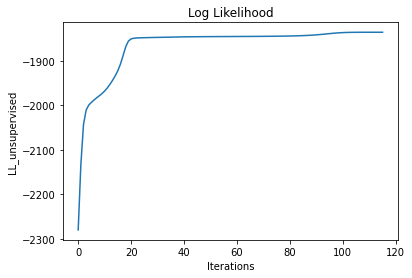

Running unsupervised EM algorithm...
Converged after a total of 163 iterations


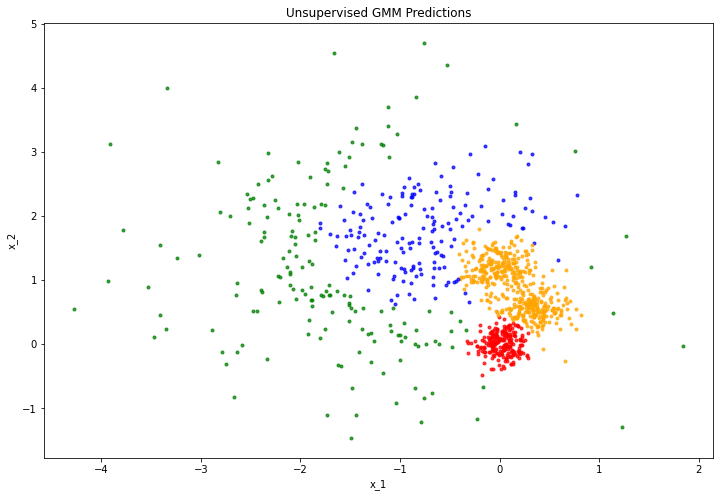

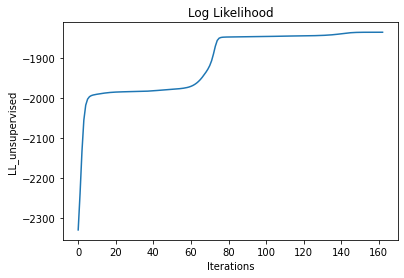

Running unsupervised EM algorithm...
Converged after a total of 78 iterations


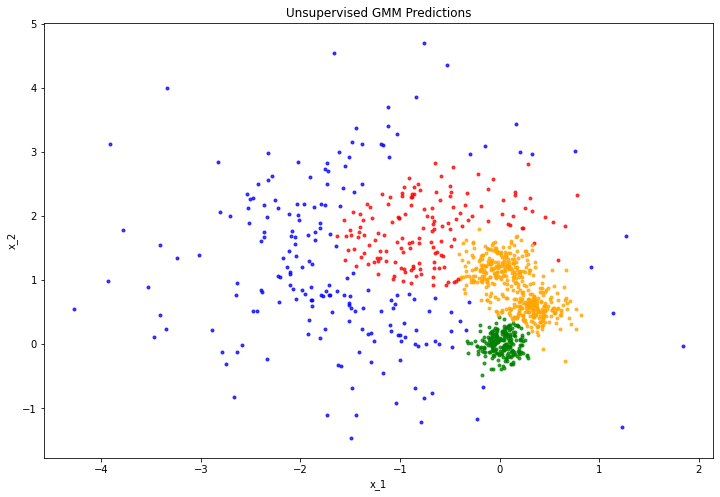

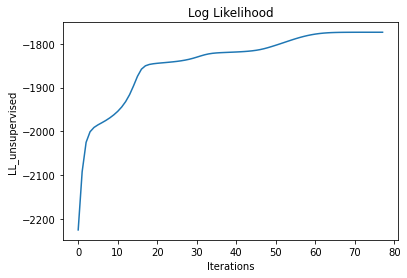

Running semi_supervised EM algorithm...
Converged after a total of 22 iterations


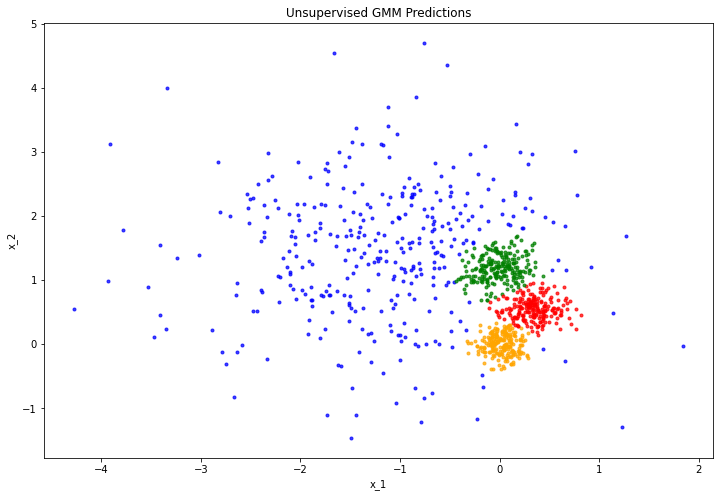

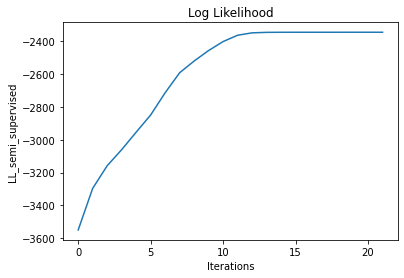

Running semi_supervised EM algorithm...
Converged after a total of 24 iterations


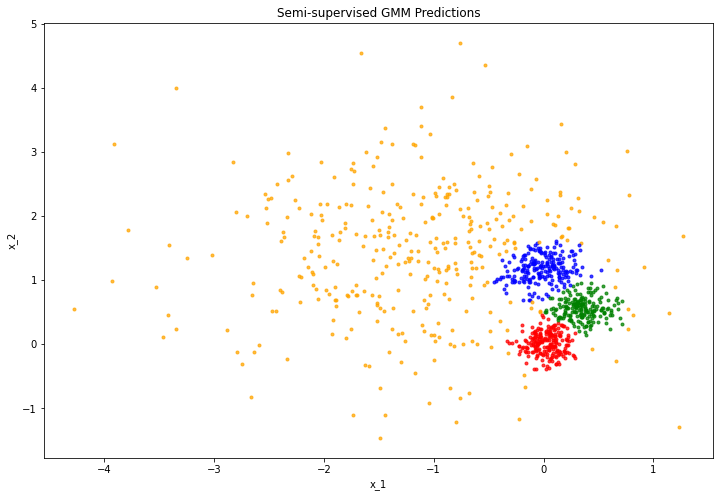

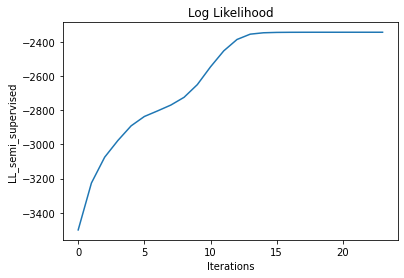

Running semi_supervised EM algorithm...
Converged after a total of 27 iterations


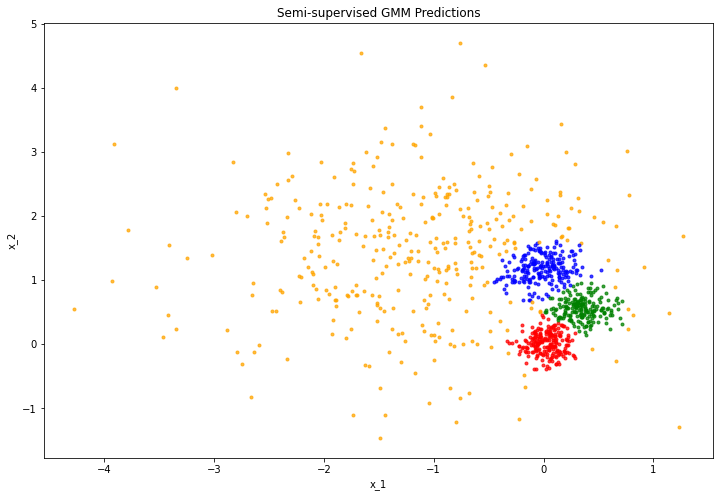

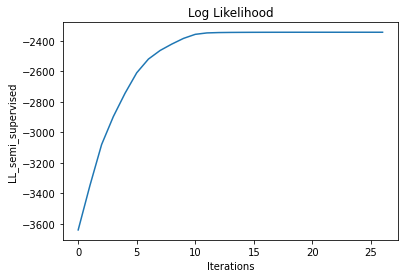

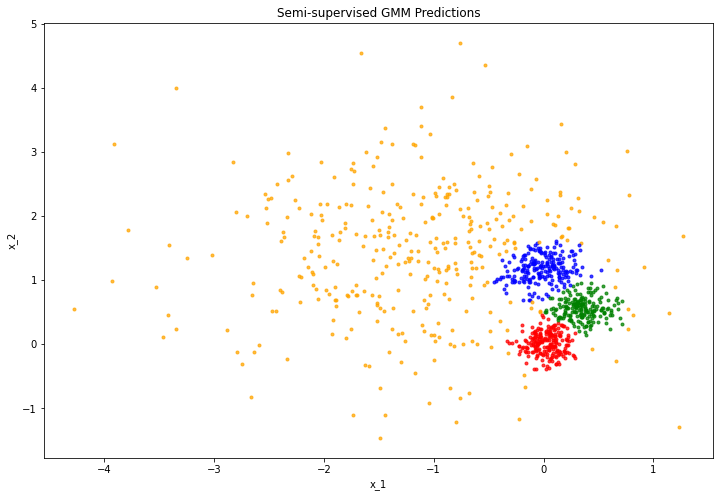

In [49]:
if __name__ == '__main__':
    np.random.seed(229)
    # Run NUM_TRIALS trials to see how different initializations
    # affect the final predictions with and without supervision
    for t in range(NUM_TRIALS):
        main('unsupervised', trial_num=t)

        # *** START CODE HERE ***
        # Once you've implemented the semi-supervised version,
        # uncomment the following line.
        # You do not need to add any other lines in this code block.
    for t in range(NUM_TRIALS):   
        main('semi_supervised', trial_num=t)